In [4]:
#!pip install fasttext
!rm -rf ReST/
!git clone https://github.com/alessandrocuda/ReSt
!wget http://www.italianlp.it/twitter128.bin
!mv /content/twitter128.bin /content/ReSt/results/model/word2vec

fatal: destination path 'ReSt' already exists and is not an empty directory.
--2021-06-23 14:53:32--  http://www.italianlp.it/twitter128.bin
Resolving www.italianlp.it (www.italianlp.it)... 146.48.92.46, 2a00:1620:c0:5c::8
Connecting to www.italianlp.it (www.italianlp.it)|146.48.92.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613808129 (585M) [application/octet-stream]
Saving to: ‘twitter128.bin’

twitter128.bin      100%[===================>] 585.37M  6.23MB/s    in 1m 48s  

2021-06-23 14:55:22 (5.40 MB/s) - ‘twitter128.bin’ saved [613808129/613808129]



In [1]:
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#import fasttext.util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import datapath

import sys
root_project = "/content/ReSt/"
#root_project = "/Users/Alessandro/Dev/repos/ReSt/"
#root_project = "/home/jupyter/ReSt/"
root_project = "/storagenfs/a.cudazzo1/ReSt/"

sys.path.append(root_project)
from src.data.utils import load_csv_to_dict, set_unkmark_token, load_data, to_emb
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb, get_index_key_pos_association, get_one_hot_pos
#load metrics
from src.utils.metrics import f1_macro
#load callbacks
from src.utils.callbacks import ReturnBestEarlyStopping, FCallback

from src.utils.utils import save_data_p, load_data_p, plotF1_macro, plotLoss, plotHistory
%load_ext autoreload
%autoreload 2

In [2]:
print(tf.__version__)

2.4.1


# Path

In [3]:
#PATH
dataset_dev_path           = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
w2v_bin_path               = root_project + 'results/model/word2vec/twitter128.bin'

In [4]:
#load dataset dictionary
dataset_dev = load_csv_to_dict(dataset_dev_path)
dataset_test_tweets = load_csv_to_dict(dataset_test_tweets_path)

In [5]:
dataset_dev.keys()

dict_keys(['id', 'text', 'hs', 'stereotype', 'processed_text', 'text_length', 'hashtags', '%CAPS-LOCK words', 'esclamations', 'questions', 'tokens', 'lemma', 'pos', 'dep', 'word_polarity', 'sentence_positive', 'sentence_negative', 'sentence_neutral', 'stem', '%bad_words'])

# Embedding

In [6]:
#load word2vec and embedding_matrix
w2v = KeyedVectors.load_word2vec_format(datapath(w2v_bin_path), binary=True)
index_to_key, key_to_index = get_index_key_association(w2v)
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, index_to_key)

WORD_EMB_SIZE = 128
VOCAB_SIZE = vocab_size

Vocab_size is 1170776
Embedding_matrix with unk word loaded
Shape (1170777, 128)


In [7]:
# load pos embedding
index_to_key_pos, key_to_index_pos = get_index_key_pos_association(X = dataset_dev["pos"])
index_to_onehot_pos = get_one_hot_pos(index_to_key_pos)

In [8]:
index_to_onehot_pos

{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 1: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 2: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 3: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 4: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 5: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 6: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 7: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 8: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 9: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 10: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 11: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 12: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 13: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 14: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 15: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 16: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [9]:
dataset_dev.keys()

dict_keys(['id', 'text', 'hs', 'stereotype', 'processed_text', 'text_length', 'hashtags', '%CAPS-LOCK words', 'esclamations', 'questions', 'tokens', 'lemma', 'pos', 'dep', 'word_polarity', 'sentence_positive', 'sentence_negative', 'sentence_neutral', 'stem', '%bad_words'])

# DATA

In [10]:
#load dev/test
MAX_TEXT_LEN = 65

X, X_pos, X_extra_feature, y = load_data(dataset_dev, w2v, key_to_index, key_to_index_pos, embedding_matrix, MAX_TEXT_LEN)
X_e = to_emb(X, embedding_matrix)
X_pos_e = to_emb(X_pos, index_to_onehot_pos)

X_test, X_test_pos, X_test_extra_feature, y_test = load_data(dataset_test_tweets, w2v, key_to_index, key_to_index_pos, embedding_matrix, MAX_TEXT_LEN)
X_test_e = to_emb(X_test, embedding_matrix)
X_test_pos_e = to_emb(X_test_pos, index_to_onehot_pos)

# Split

In [11]:
X_train, X_val, X_pos_train, X_pos_val, X_extra_feature_train, X_extra_feature_val, y_train, y_val = train_test_split(X_e, X_pos_e, X_extra_feature, y, test_size=0.10, random_state=128)

In [12]:
input_train = {"text": X_train, "pos": X_pos_train, "extra": X_extra_feature_train}
input_val = {"text": X_val, "pos": X_pos_val, "extra": X_extra_feature_val}
input_test = {"text": X_test_e, "pos": X_test_pos_e, "extra": X_test_extra_feature}

# model: text + pos + extra features

In [13]:
def kim_cnn_pos(input_shape, filters = 256, filter_sizes = [2,4,6], dropout = 0.5, hn=128, lr=0.01, print_model=False):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
    from tensorflow.keras.layers import Dense, Input, Flatten, Activation
    from tensorflow.keras.layers import Concatenate
    from tensorflow.keras.regularizers import l2

    """ HyperParameters """

    text_seq_input = Input(shape=input_shape, name="text")
    pos_seq_input = Input(shape=(65,16, ), name="pos")
    extra_feature = Input(shape=(8,), name="extra")

    convs = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=filters, kernel_size=filter_size)(text_seq_input)
        l_relu = Activation("relu")(l_conv)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs.append(l_pool)
    
    convs_pos = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=filters, kernel_size=filter_size)(pos_seq_input)
        l_relu = Activation("relu")(l_conv)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs_pos.append(l_pool)

    l_merge     = Concatenate(axis=1)(convs)
    l_flat      = Flatten()(l_merge)
    l_merge_pos = Concatenate(axis=1)(convs_pos)
    l_flat_pos  = Flatten()(l_merge_pos)

    #l_avg       = tf.keras.layers.maximum([l_flat, l_flat_pos])

    input_ff    = Concatenate(axis=1)([l_flat, l_flat_pos, extra_feature])
    l_drop      = Dropout(dropout)(input_ff)
    l_hidden    = Dense(hn, activation='relu')(l_drop)
    l_drop      = Dropout(dropout)(l_hidden)
    l_out_st    = Dense(1, activation='sigmoid', name="st")(l_drop)  #dims output

    model_cnn   = Model(inputs=[text_seq_input, pos_seq_input, extra_feature], outputs=l_out_st)
    if print_model:
        model_cnn.summary()
        tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
    
    model_cnn.compile(
        loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False),
        metrics= [f1_macro]
    )

    return model_cnn

In [74]:
#del model
model = kim_cnn_pos((65,128, ), filters = 128, filter_sizes = [2,3,4], dropout = 0.5, hn=256, lr=0.001, print_model=True)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 65, 128)]    0                                            
__________________________________________________________________________________________________
pos (InputLayer)                [(None, 65, 16)]     0                                            
__________________________________________________________________________________________________
conv1d_150 (Conv1D)             (None, 64, 128)      32896       text[0][0]                       
__________________________________________________________________________________________________
conv1d_151 (Conv1D)             (None, 63, 128)      49280       text[0][0]                       
___________________________________________________________________________________________

In [ ]:
input_train = {"text": X_train, "pos": X_pos_train, "extra": X_extra_feature_train}
input_val = {"text": X_val, "pos": X_pos_val, "extra": X_extra_feature_val}
input_test = {"text": X_test_e, "pos": X_test_pos_e, "extra": X_test_extra_feature}

f1_callback = FCallback(validation = (input_test, y_test), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="min", restore_best_weights=True)

history = model.fit(input_train, y_train, batch_size=64, epochs=200, validation_data=(input_val, y_val), callbacks=[f1_callback, best_callback], verbose = 1)

Epoch 1/200


In [ ]:
y_val_pred = np.where(model.predict(input_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.6928879310344827
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       369
           1       0.64      0.77      0.70       315

    accuracy                           0.69       684
   macro avg       0.70      0.70      0.69       684
weighted avg       0.71      0.69      0.69       684



In [ ]:
y_test_pred = np.where(model.predict(input_test) > 0.5, 1, 0)
print(y_test.shape)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

(1263,)
0.6675825573056794
              precision    recall  f1-score   support

           0       0.83      0.50      0.63       694
           1       0.59      0.88      0.71       569

    accuracy                           0.67      1263
   macro avg       0.71      0.69      0.67      1263
weighted avg       0.72      0.67      0.66      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'val_loss', 'val_f1'])


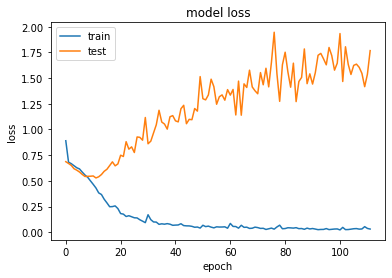

In [ ]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Result GridSearch

In [ ]:
import pickle

grid_result0 = pickle.load( open( root_project +"script/grid_search/kim_cnn_pos/grid_result0.p", "rb" ) )
grid_result1 = pickle.load( open( root_project + "script/grid_search/kim_cnn_pos/grid_result1.p", "rb" ) )
grid_result2 = pickle.load( open( root_project + "script/grid_search/kim_cnn_pos/grid_result2.p", "rb" ) )

In [ ]:
grid_result0[0]

{'hyper_parm': {'filters': 32,
  'filter_sizes': [2, 3, 4],
  'dropout': 0.1,
  'hn': 64,
  'lr': 0.1},
 'mean': 0.3626727284027465,
 'std': 0.004393792299606947,
 'folds': {'fold_0': {'f1': 0.38665510234532713,
   'val_f1': 0.36705179388202946},
  'fold_1': {'f1': 0.3553483553483553, 'val_f1': 0.36490250696378834},
  'fold_2': {'f1': 0.3627634387333001, 'val_f1': 0.3632097942814797},
  'fold_3': {'f1': 0.3639769996671354, 'val_f1': 0.3639246295505823},
  'fold_4': {'f1': 0.35854161298634374, 'val_f1': 0.35427491733585265}}}

In [ ]:
grid_result_d = {
    'hyper_parm' : [],
    'mean': [],
    'std': [],
    'folds': []
}
for elem in grid_result0:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])
for elem in grid_result1:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])
for elem in grid_result2:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])

In [ ]:
df_result = pd.DataFrame(grid_result_d)

In [ ]:
pd.set_option('display.max_colwidth', None)
df_result.sort_values(by=['mean'], ascending=False)[0:20][["hyper_parm","mean", "std"]]

,hyper_parm,mean,std
200,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.0001}",0.705642,0.009181
206,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 512, 'lr': 0.0001}",0.705432,0.006158
118,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.703095,0.011536
202,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.001}",0.702334,0.009400
203,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.701581,0.007757
244,"{'filters': 256, 'filter_sizes': [4, 5, 6], 'dropout': 0.1, 'hn': 64, 'lr': 0.001}",0.700844,0.012751
119,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.0001}",0.700827,0.011337
199,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.700151,0.010281
122,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.700008,0.014635
257,"{'filters': 256, 'filter_sizes': [4, 5, 6], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.699798,0.006238


In [ ]:
final_grid = pickle.load( open( root_project +"script/grid_search/kim_cnn_pos/final_grid_result.p", "rb" ) )
df_result = pd.DataFrame(final_grid)
df_result.sort_values(by=['val_f1_macro_mean'], ascending=False)[0:3][["hyper_parm","loss_mean","loss_std","f1_macro_mean", "f1_macro_std","val_loss_mean","val_loss_std","val_f1_macro_mean","val_f1_macro_std"]]

,hyper_parm,loss_mean,loss_std,f1_macro_mean,f1_macro_std,val_loss_mean,val_loss_std,val_f1_macro_mean,val_f1_macro_std
3,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 128, 'lr': 0.0001}",0.396472,0.015924,0.836715,0.008655,0.561911,0.008446,0.704720,0.011407
10,"{'filters': 512, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 512, 'lr': 0.001}",0.366962,0.067959,0.871601,0.042369,0.561648,0.017478,0.704681,0.010627
9,"{'filters': 512, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 128, 'lr': 0.0001}",0.346777,0.034851,0.873030,0.022325,0.560784,0.007240,0.703948,0.008851


# Retrain the final model and save

In [93]:
model = kim_cnn_pos((65,128, ), filters = 512, filter_sizes = [2,3,4], dropout = 0.5, hn=512, lr=0.001, print_model=False)
best_callback = ReturnBestEarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="min", restore_best_weights=True)
f1_callback = FCallback(validation = (input_val, y_val), verbose=True)    


history = model.fit(input_train, y_train, batch_size=128, epochs=20, validation_data=(input_val, y_val), callbacks=[f1_callback, best_callback], verbose = 2)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


49/49 - 4s - loss: 1.2805 - f1_macro: 0.4745 - val_loss: 0.6830 - val_f1_macro: 0.3516
— val_f1: 0.35042735042735046
Epoch 2/20
49/49 - 2s - loss: 0.6734 - f1_macro: 0.4940 - val_loss: 0.6506 - val_f1_macro: 0.5706
— val_f1: 0.56477495472524
Epoch 3/20
49/49 - 2s - loss: 0.6500 - f1_macro: 0.5872 - val_loss: 0.6255 - val_f1_macro: 0.6545
— val_f1: 0.6563404474599561
Epoch 4/20
49/49 - 2s - loss: 0.6240 - f1_macro: 0.6224 - val_loss: 0.5984 - val_f1_macro: 0.6839
— val_f1: 0.6826338983123329
Epoch 5/20
49/49 - 2s - loss: 0.5911 - f1_macro: 0.6717 - val_loss: 0.5808 - val_f1_macro: 0.6831
— val_f1: 0.6814214248749353
Epoch 6/20
49/49 - 2s - loss: 0.5623 - f1_macro: 0.6923 - val_loss: 0.5600 - val_f1_macro: 0.7096
— val_f1: 0.7055355058417845
Epoch 7/20
49/49 - 2s - loss: 0.5345 - f1_macro: 0.7159 - val_loss: 0.5768 - val_f1_macro: 0.6744
— val_f1: 0.6743255521386637
Epoch 8/20
49/49 - 2s - loss: 0.5039 - f1_macro: 0.7412 - val_loss: 0.5351 - val_f1_macro: 0.7175
— val_f1: 0.7199407486167

macro_f1_train: 0.8433469027013232
macro_f1_val: 0.719940748616789
macro_f1_test: 0.7147696476964769


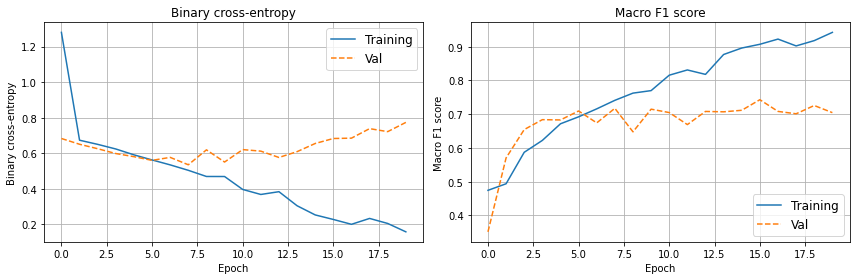

In [94]:
y_train_pred = np.where(model.predict(input_train) > 0.5,1,0)
print("macro_f1_train: {}".format(f1_score(y_train, y_train_pred, average="macro")))

y_val_pred = np.where(model.predict(input_val) >0.5,1,0)
print("macro_f1_val: {}".format(f1_score(y_val, y_val_pred, average="macro")))

y_test_pred = np.where(model.predict(input_test) > 0.5,1,0)
print("macro_f1_test: {}".format(f1_score(y_test, y_test_pred, average="macro")))

plotHistory(history.history)

In [95]:
model.save(root_project + 'results/model/d_kcnn/d_kcnn.h5')
save_data_p(history.history, root_project + 'results/model/d_kcnn/d_kcnn_history.p')

# Final model

In [14]:
dependencies = {
    'f1_macro': f1_macro
}
model = tf.keras.models.load_model(root_project + 'results/model/d_kcnn/d_kcnn.h5', custom_objects=dependencies)
model.compile(loss= tf.keras.losses.BinaryCrossentropy(), metrics= [f1_macro])
history = load_data_p(root_project + 'results/model/d_kcnn/d_kcnn_history.p')

In [104]:
model.evaluate(input_train, y_train)
model.evaluate(input_val, y_val)
model.evaluate(input_test, y_test)

40/40 [==============================] - 0s 10ms/step - loss: 0.5522 - f1_macro: 0.5971


[0.5522225499153137, 0.5970761775970459]

In [105]:
y_train_pred = np.where(model.predict(input_train) >0.5,1,0)
print(f1_score(y_train, y_train_pred, average="macro"))
print(classification_report(y_train, y_train_pred))

0.8433469027013232
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      3426
           1       0.80      0.87      0.83      2729

    accuracy                           0.84      6155
   macro avg       0.84      0.85      0.84      6155
weighted avg       0.85      0.84      0.84      6155



In [106]:
y_val_pred = np.where(model.predict(input_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.719940748616789
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       369
           1       0.69      0.72      0.70       315

    accuracy                           0.72       684
   macro avg       0.72      0.72      0.72       684
weighted avg       0.72      0.72      0.72       684



In [107]:
y_test_pred = np.where(model.predict(input_test) >0.5,1,0)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

0.7147696476964769
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       694
           1       0.64      0.82      0.72       569

    accuracy                           0.71      1263
   macro avg       0.73      0.72      0.71      1263
weighted avg       0.74      0.71      0.71      1263



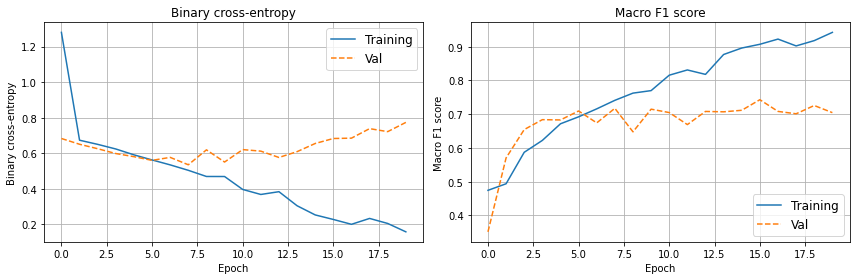

In [108]:
plotHistory(history)

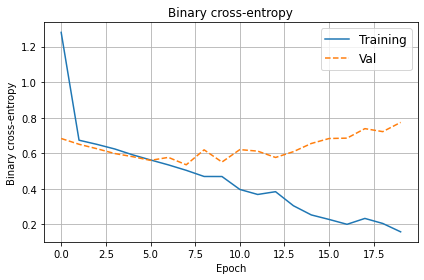

In [109]:
plotLoss(history)

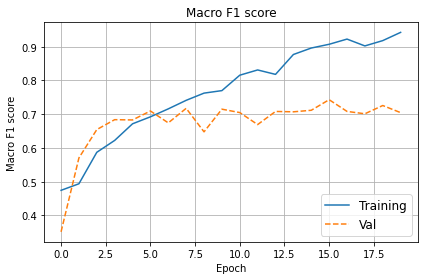

In [110]:
plotF1_macro(history)

In [15]:
for sentence in dataset_test_tweets["processed_text"][10:15]:
    print(sentence)
    print()

Tutti i politici rubano , hanno rubato e ruberanno ! La Fornero ha rubato 10 mila euro a mio padre ! Ma basta con lecchini di immigrati che si ciondolano tutto il giorno con cellulari stracostosi e sigarette e per noia violentano o rubano ! Vuoi che tuo figlio conosca il Natale o no ?

Rosarno , le case popolari ? Solo agli immigrati Hanno avuto bisogno di governi non eletti , di gente imposta ad un popolo disarmato . Una volta messi li , i Vigliacchi hanno dato inizio alla ns fine ! Se e quando si scatenerà la rabbia vera , ne farò parte ! !

i musulmano ammazzano tutti quelli che per il loro fumoso cervello sono " infedeli " . i nostri terroristi istituzionali ci obbligano ad accogliere e mantenere i nostri assassini

l' accusa della sinistraglia cialtrona immigrazionista a < Salvini > è che ha impedito che altri parassiti afro islamici infestassero l' Italia e ha danneggiato il business dell' immigrazione clandestina . Solita feccia rosicona . < Salvini Non Mollare >

Alle idiote pd

In [16]:
y_test[10:15]


array([1, 0, 1, 1, 0])

In [18]:
np.where(model.predict({"text": X_test_e[10:15], "pos": X_test_pos_e[10:15], "extra": X_test_extra_feature[10:15]}) > 0.5,1,0)

array([[1],
       [1],
       [1],
       [1],
       [1]])

# ----------------------------------------------

# ensemble predictions

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

models = []

data = {"text": X_e, "pos": X_pos_e, "extra": X_extra_feature, "target": y}
data_test = {"text": X_test_e, "pos": X_test_pos_e, "extra": X_test_extra_feature, "target": y_test}
i=1
for train_index_fold, val_index_fold in kf.split(data["text"]):
        name_fold = "fold_{}".format(i)
        print(name_fold)
        i+=1
        
        #DATA
        X_train = {"text": data["text"][train_index_fold], "pos": data["pos"][train_index_fold], "extra": data["extra"][train_index_fold]}
        Y_train = data["target"][train_index_fold]
        X_val = {"text": data["text"][val_index_fold], "pos": data["pos"][val_index_fold], "extra": data["extra"][val_index_fold]}
        Y_val = data["target"][val_index_fold]

        #print(hyper_param)
        input_shape = (X_train["text"][0].shape[0], X_train["text"][0].shape[1],)
        model = kim_cnn_pos((65,128, ), filters = 256, filter_sizes = [2,3,4], dropout = 0.5, hn=64, lr=0.0001, print_model=False)
        best_callback = ReturnBestEarlyStopping(monitor="val_loss", patience=50, verbose=0, mode="min", restore_best_weights=True)
        history = model.fit(X_train, Y_train, batch_size=64, epochs=200, validation_data=(X_val, Y_val), callbacks=[best_callback], verbose = 0)
        
        models.append(model)
        X_test = {"text": data_test["text"], "pos": data_test["pos"], "extra": data_test["extra"]}
        y_pred = np.where(model.predict(X_test) >0.5,1,0)

        print(f1_score(data_test["target"], y_pred, average="macro"))

fold_1
0.6884699604842567
fold_2
0.6800970162902645
fold_3
0.6804990508898421
fold_4
0.6906347344301067
fold_5
0.6883460236886633


In [ ]:
def ensemble_predictions(members, X):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(X) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats[:,0])
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

In [ ]:
X_test = {"text": data_test["text"], "pos": data_test["pos"], "extra": data_test["extra"]}
y_pred = ensemble_predictions(models, X_test)
print(classification_report(y_test,y_pred))


[0 0 0 0 0]
(5, 1263)
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       694
           1       0.61      0.83      0.71       569

    accuracy                           0.69      1263
   macro avg       0.71      0.70      0.69      1263
weighted avg       0.72      0.69      0.69      1263

